# Starters

## Imports

In [189]:
# import skimage
import numpy as np
import scipy.ndimage
from skimage import data, io, color, filters, morphology, util
from skimage.io import imsave
# from skimage import exposure, measure, feature, segmentation, restoration
import matplotlib.pyplot as plt
# from skimage.util import img_as_ubyte
import scipy.ndimage as ndi
import pandas as pd
# import seaborn as sns
import os
from PIL import Image
from scipy import ndimage
import cv2
from skimage import measure
# import torch
import glob
import seaborn as sns
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import re

## Switches and Constants

In [4]:
# For saving the images from interpolations
saveimgs = False
saveimgs = True

# For saving new figures from the runs and the plotting
savefigs = False
savefigs = True

## Checking Versions and Conda Env

In [5]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Define Functions

In [190]:
def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

def sort_nicely( l ):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

## Set Directories

In [191]:
SCRIPTDIR = os.path.realpath('./')
SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir('/scratch/ns4964/lionnet/inputs/interpolated')
INTERPDIR = os.getcwd()

os.chdir('/scratch/ns4964/lionnet/inputs/interpolated/Figures/')
FIGDIR = os.getcwd()
# os.listdir()

## Bring in Data

In [192]:
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)
# imgfolders

In [193]:
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath']=''
imgdf['imagepath']=''
imgdf['labelpath']=''
imgdf['zlayers']=''
imgdf['x']=''
imgdf['y']=''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR,imgdf.iloc[index]['imgfolder'])
    imgdf.at[index,'gappath'] = os.path.join(indir,'gap.tif')
    imgdf.at[index,'imagepath'] = os.path.join(indir,'image.tif')
    imgdf.at[index,'labelpath'] = os.path.join(indir,'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index,'zlayers'] = skimg.shape[0]
    imgdf.at[index,'x'] = skimg.shape[1]
    imgdf.at[index,'y'] = skimg.shape[2]


In [194]:
imgdf.head()

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [11]:
im = imgdf['imagepath'][0]
# print(test)

skimg = io.imread(im, plugin='tifffile')
print(skimg.shape[0])
print("zslice,height,width")

7
zslice,height,width


(7, 1024, 1024) 
 Showing Z-stack 7 of 7


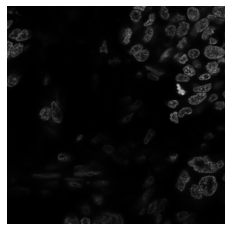

In [12]:
showtif(imgdf['imagepath'][0], 6, verbose=True)

# Laying the idea down

In [13]:
im = imgdf.labelpath[0]
im

'/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_11/label.tif'

In [14]:
skimg = io.imread(im, plugin='tifffile')
print(skimg.shape)
print(skimg.dtype)

(7, 1024, 1024)
uint8


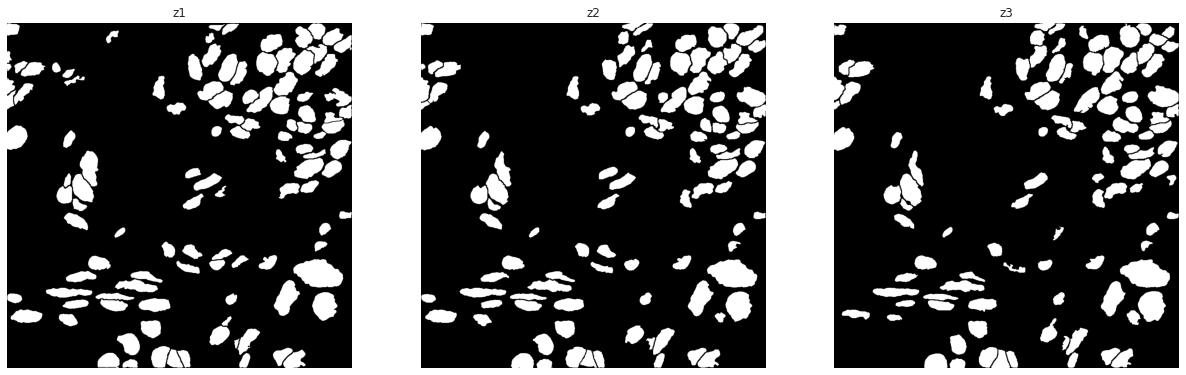

In [15]:
z1 = skimg[1]
z2 = skimg[2]
z3 = skimg[3]

plt.figure(figsize=(21,15))

plt.subplot(1,3,1)
plt.title('z1')
plt.axis('off')
plt.imshow(z1, cmap = 'gray')

plt.subplot(1,3,2)
plt.title('z2')
plt.axis('off')
plt.imshow(z2, cmap = 'gray')

plt.subplot(1,3,3)
plt.title('z3')
plt.axis('off')
plt.imshow(z3, cmap = 'gray')

In [16]:

intz2 = cv2.addWeighted(z1,0.5,z3,0.5,0)
dif =  cv2.subtract(z2,intz2)
print(intz2.dtype)
np.unique(intz2)

uint8


array([  0, 128, 255], dtype=uint8)

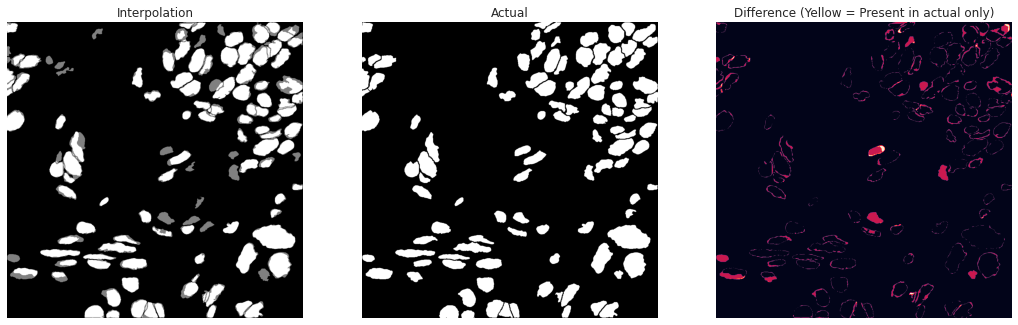

In [17]:
plt.figure(figsize=(18,12))


plt.subplot(1,3,1)
plt.title('Interpolation')
plt.axis('off')
plt.imshow(intz2, cmap = 'gray')

plt.subplot(1,3,2)
plt.title('Actual')
plt.axis('off')
plt.imshow(z2, cmap='gray')

plt.subplot(1,3,3)
plt.title('Difference (Yellow = Present in actual only)')
plt.axis('off')
plt.imshow(dif)

# Make a function to add two images

## Experimenting with Setup


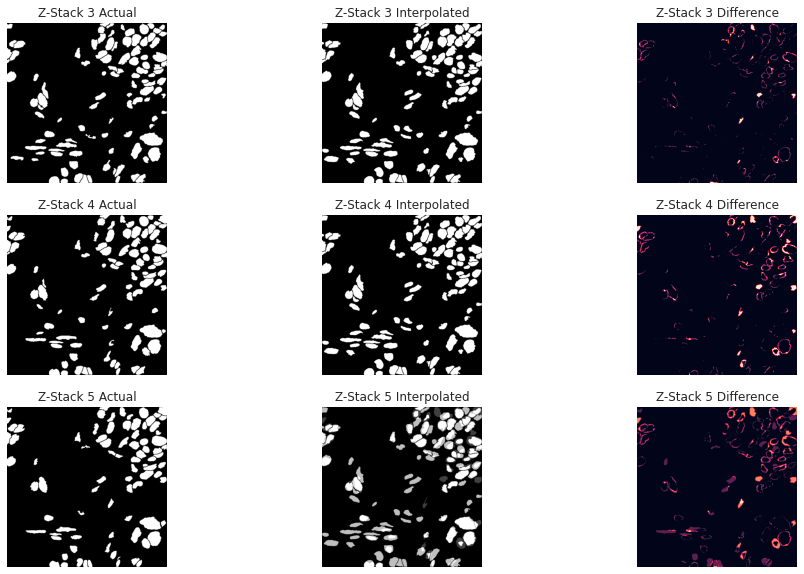

In [18]:
imagefile = imgdf.labelpath[0]
zstart = 2
zend = 6
compare = True

skimg = io.imread(imagefile, plugin='tifffile')
startarray = skimg[zstart]
endarray = skimg[zend]
diff = zend-zstart
chunk = 1/diff
outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
newtifcounter = 0
for i in range(diff-1):
    znew = i+1
    zstartweight = (zend-znew)*chunk
    zendweight = (znew-zstart)*chunk
    outtifs[newtifcounter]= cv2.addWeighted(startarray,zstartweight,endarray,zendweight,0)
    newtifcounter+=1
if compare:
    plt.figure(figsize=(16,10))
    for i in range(diff-1):
        zoffocus = i+1
        actual = skimg[zstart+zoffocus].astype(np.uint8)
        interpolated = outtifs[i].astype(np.uint8)
        dif = cv2.subtract(actual,interpolated)

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-2)
        plt.title(f'Z-Stack {zstart+zoffocus} Actual')
        plt.axis('off')
        plt.imshow(skimg[zstart+zoffocus],cmap='gray')

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-1)
        plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
        plt.axis('off')
        plt.imshow(outtifs[i],cmap='gray')

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3))
        plt.title(f'Z-Stack {zstart+zoffocus} Difference')
        plt.axis('off')
        plt.imshow(dif)

In [19]:
diff = 6-1
for i in range(diff-1):
    print(i+1)

1
2
3
4


## Function 1 (interpZ) : Just the Average

In [20]:
# Working
def interpZ(imagefile, zstart, zend, compare = True):
    skimg = io.imread(imagefile, plugin='tifffile')
    startarray = skimg[zstart]
    endarray = skimg[zend]
    diff = zend-zstart
    chunk = 1/diff
    outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    newtifcounter = 0
    for i in range(diff-1):
        znew = i+1
        zstartweight = (zend-znew)*chunk
        zendweight = (znew-zstart)*chunk
        outtifs[newtifcounter]= cv2.addWeighted(startarray,zstartweight,endarray,zendweight,0)
        newtifcounter+=1
    if compare:
        plt.figure(figsize=(16,10))
        for i in range(diff-1):
            zoffocus = i+1
            actual = skimg[zstart+zoffocus].astype(np.uint8)
            interpolated = outtifs[i].astype(np.uint8)
            dif = cv2.subtract(actual,interpolated)

            plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-2)
            plt.title(f'Z-Stack {zstart+zoffocus} Actual')
            plt.axis('off')
            plt.imshow(skimg[zstart+zoffocus],cmap='gray')

            plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-1)
            plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
            plt.axis('off')
            plt.imshow(outtifs[i],cmap='gray')

            plt.subplot(outtifs.shape[0], 3, (zoffocus*3))
            plt.title(f'Z-Stack {zstart+zoffocus} Difference')
            plt.axis('off')
            plt.imshow(dif)
    return outtifs

In [21]:
testim = imgdf.labelpath[0]

# skimg =io.imread(testim, plugin='tifffile')
# plt.imshow(skimg[0])

# interpzs = interpZ(testim,1,6)

# np.unique(interpzs[1])
# interpzs.shape
# interpzs[1]

# Function 2 (interpZv2): Adding a distance transform to the output

## Testing the base parts

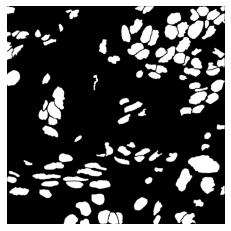

In [22]:
testimpath = imgdf.labelpath[0]
testimg =io.imread(testim, plugin='tifffile')
showtif(testimg)


In [23]:
imagefile = testimpath
zend = 3
zstart = 0

skimg = io.imread(imagefile, plugin='tifffile')
startarray = skimg[zstart]
startdist = ndimage.distance_transform_cdt(startarray)
endarray = skimg[zend]
enddist = ndimage.distance_transform_cdt(endarray)
diff = zend-zstart
chunk = 1/diff
outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
newtifcounter = 0
for i in range(diff-1):
    znew = i+1
    zstartweight = (zend-znew)*chunk
    zendweight = (znew-zstart)*chunk
    outtifs[newtifcounter]= cv2.addWeighted(startdist,zstartweight,enddist,zendweight,0)
    newtifcounter+=1


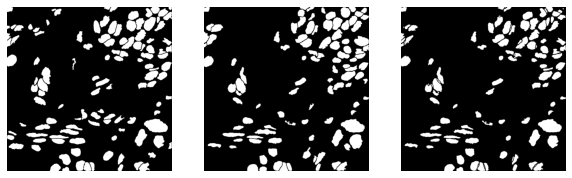

In [24]:
# Find the consensus region between the start z and end z.
andmap = np.logical_and(skimg[zstart],skimg[zend])
plt.figure(figsize=(10,15))
plt.subplot(1,3,1)
showtif(skimg[zstart])
plt.subplot(1,3,2)
showtif(skimg[zend])
plt.subplot(1,3,3)
showtif(andmap)

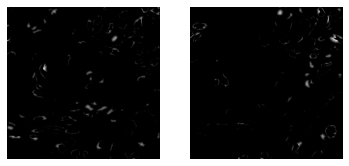

In [25]:
# get the distance map of the start z and end z, remove areas that are in consensus.
start = startdist*np.invert(andmap)
end = enddist*np.invert(andmap)

plt.subplot(1,2,1)
showtif(start)
plt.subplot(1,2,2)
showtif(end)

In [26]:
# Start by making a sorted list of the unique values of the distance map.
# Cut the lower portion of each list according to the weight for the corresponding image.

startvals = sorted(np.unique(start), reverse=True)
startvalratio = int(round(len(sorted(np.unique(start), reverse=True))*zstartweight,0))
cutstartvals = startvals[:startvalratio]

endvals = sorted(np.unique(end), reverse=True)
endvalratio = int(round(len(sorted(np.unique(end), reverse=True))*zendweight,0))
cutendvals = endvals[:endvalratio]

print(startvals)
print(endvals)
print(zstartweight)
print(cutstartvals)
print(zendweight)
print(cutendvals)

[21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
0.3333333333333333
[21, 20, 19, 18, 17, 16, 15]
0.6666666666666666
[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7]


[  0 255]


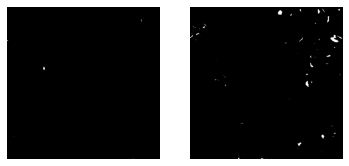

In [27]:
# Filter out the distance map values that are not in the cut part of the list and set the values to 255
# startsignal = (start >= cutstartvals[-1])*255
# endsignal = (end>= cutendvals[-1])*255

startsignal = (np.isin(start,cutstartvals))*255
endsignal = (np.isin(end,cutendvals))*255

print(np.unique(endsignal))
plt.subplot(1,2,1)
showtif(startsignal)
plt.subplot(1,2,2)
showtif(endsignal)

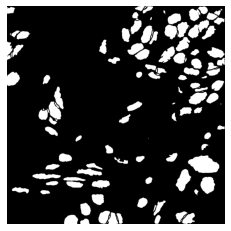

In [28]:
# add it back to the consensus map for the final image
final = startsignal+endsignal+(andmap*255)

showtif(final)


## Making the function

In [29]:
def interpZv2(imagefile, zstart, zend, compare = True):
    skimg = io.imread(imagefile, plugin='tifffile')
    startarray = skimg[zstart]
    startdist = ndimage.distance_transform_cdt(startarray)
    endarray = skimg[zend]
    enddist = ndimage.distance_transform_cdt(endarray)
    andmap = np.logical_and(skimg[zstart],skimg[zend])
    diff = zend-zstart
    chunk = 1/diff
    outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    newtifcounter = 0
    for i in range(diff-1):
        znew = i+1
        zstartweight = (zend-znew)*chunk
        zendweight = (znew-zstart)*chunk
        start = startdist*np.invert(andmap)
        end = enddist*np.invert(andmap)
        startvals = sorted(np.unique(start), reverse=True)
        startvalratio = int(round(len(sorted(np.unique(start), reverse=True))*zstartweight,0))
        cutstartvals = startvals[:startvalratio]
        endvals = sorted(np.unique(end), reverse=True)
        endvalratio = int(round(len(sorted(np.unique(end), reverse=True))*zendweight,0))
        cutendvals = endvals[:endvalratio]
        startsignal = (np.isin(start,cutstartvals))*255
        endsignal = (np.isin(end,cutendvals))*255
        outtifs[newtifcounter]= startsignal+endsignal+(andmap*255)
        newtifcounter+=1
    if compare:
        plt.figure(figsize=(16,20))
        for i in range(diff-1):
            zoffocus = i+1
            actual = skimg[zstart+zoffocus].astype(np.uint8)
            interpolated = outtifs[i].astype(np.uint8)
            dif = actual-interpolated

            plt.subplot(outtifs.shape[0]+2, 3, 2)
            plt.title(f'Z-Stack {zstart} Actual')
            plt.axis('off')
            plt.imshow(skimg[zstart],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-5)
            plt.title(f'Z-Stack {zstart+zoffocus} Actual')
            plt.axis('off')
            plt.imshow(skimg[zstart+zoffocus],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-4)
            plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
            plt.axis('off')
            plt.imshow(outtifs[i],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-3)
            plt.title(f'Z-Stack {zstart+zoffocus} Difference')
            plt.axis('off')
            plt.imshow(dif)

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-1)
            plt.title(f'Z-Stack {zend} Actual')
            plt.axis('off')
            plt.imshow(skimg[zend], cmap ='gray')

    return outtifs

In [30]:
# weighted_interps = interpZv2(imgdf.labelpath[3],1,6)

# Function 3 (interpZv3) : Use two distances per stack to find the final weight

## Testing

### Creating a Test Image Set

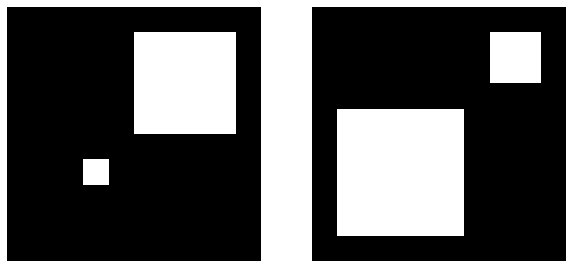

In [31]:
# # Group 1 - Smaller cell growing non-symmetrically into larger cell
# z1 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,0,0,0,0,0,0,0,0,0], #2
#                [0,0,1,1,1,0,0,0,0,0], #3
#                [0,0,1,1,1,0,0,0,0,0], #4
#                [0,0,1,1,1,0,0,0,0,0], #5
#                [0,0,0,0,0,0,0,0,0,0], #6
#                [0,0,0,0,0,0,0,0,0,0], #7
#                [0,0,0,0,0,0,0,0,0,0], #8
#                [0,0,0,0,0,0,0,0,0,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))
# z3 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,0,0,0,0,0,0,0,0,0], #2
#                [0,0,1,1,1,1,1,1,1,0], #3
#                [0,0,1,1,1,1,1,1,1,0], #4
#                [0,0,1,1,1,1,1,1,1,0], #5
#                [0,0,1,1,1,1,1,1,1,0], #6
#                [0,0,1,1,1,1,1,1,1,0], #7
#                [0,0,1,1,1,1,1,1,1,0], #8
#                [0,0,1,1,1,1,1,1,1,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))
# Group 2 - No overlap of cells, some boundaries
z1 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
               [0,0,0,0,0,1,1,1,1,0], #2
               [0,0,0,0,0,1,1,1,1,0], #3
               [0,0,0,0,0,1,1,1,1,0], #4
               [0,0,0,0,0,1,1,1,1,0], #5
               [0,0,0,0,0,0,0,0,0,0], #6
               [0,0,0,1,0,0,0,0,0,0], #7
               [0,0,0,0,0,0,0,0,0,0], #8
               [0,0,0,0,0,0,0,0,0,0], #9
               [0,0,0,0,0,0,0,0,0,0], #10
               ))
z3 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
               [0,0,0,0,0,0,0,1,1,0], #2
               [0,0,0,0,0,0,0,1,1,0], #3
               [0,0,0,0,0,0,0,0,0,0], #4
               [0,1,1,1,1,1,0,0,0,0], #5
               [0,1,1,1,1,1,0,0,0,0], #6
               [0,1,1,1,1,1,0,0,0,0], #7
               [0,1,1,1,1,1,0,0,0,0], #8
               [0,1,1,1,1,1,0,0,0,0], #9
               [0,0,0,0,0,0,0,0,0,0], #10
               ))
# Group 3 - Single cell growing into larger cell
# z1 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,0,0,0,0,0,0,0,0,0], #2
#                [0,0,0,0,0,0,0,0,0,0], #3
#                [0,0,0,0,0,0,0,0,0,0], #4
#                [0,0,0,0,1,1,0,0,0,0], #5
#                [0,0,0,0,1,1,0,0,0,0], #6
#                [0,0,0,0,0,0,0,0,0,0], #7
#                [0,0,0,0,0,0,0,0,0,0], #8
#                [0,0,0,0,0,0,0,0,0,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))
# z3 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,1,1,1,1,1,1,1,1,0], #2
#                [0,1,1,1,1,1,1,1,1,0], #3
#                [0,1,1,1,1,1,1,1,1,0], #4
#                [0,1,1,1,1,1,1,1,1,0], #5
#                [0,1,1,1,1,1,1,1,1,0], #6
#                [0,1,1,1,1,1,1,1,1,0], #7
#                [0,1,1,1,1,1,1,1,1,0], #8
#                [0,1,1,1,1,1,1,1,1,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))
# Group 4 - One cell growing and one cell disappearing with no overlap
# z1 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,0,0,0,0,0,0,0,0,0], #2
#                [0,0,0,0,0,0,0,0,0,0], #3
#                [0,0,0,1,0,0,0,0,0,0], #4
#                [0,0,0,0,0,0,0,0,0,0], #5
#                [0,0,0,0,0,0,0,0,0,0], #6
#                [0,0,0,0,0,0,0,0,0,0], #7
#                [0,0,0,0,0,0,1,1,0,0], #8
#                [0,0,0,0,0,0,1,1,0,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))
# z3 = np.array(([0,0,0,0,0,0,0,0,0,0], #1
#                [0,1,1,1,1,1,0,0,0,0], #2
#                [0,1,1,1,1,1,0,0,0,0], #3
#                [0,1,1,1,1,1,0,0,0,0], #4
#                [0,1,1,1,1,1,0,0,0,0], #5
#                [0,1,1,1,1,1,0,0,0,0], #6
#                [0,0,0,0,0,0,0,0,0,0], #7
#                [0,0,0,0,0,0,0,0,0,0], #8
#                [0,0,0,0,0,0,0,0,0,0], #9
#                [0,0,0,0,0,0,0,0,0,0], #10
#                ))

plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
showtif(z1)
plt.subplot(1,2,2)
showtif(z3)

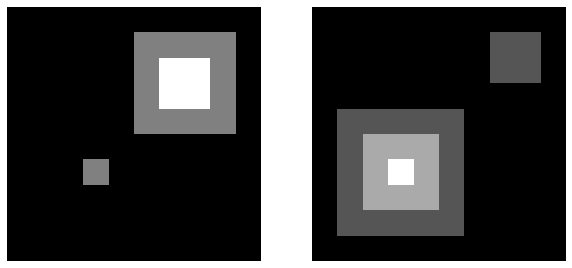

In [32]:
# Distance Maps
z1dist = ndimage.distance_transform_cdt(z1)
z3dist = ndimage.distance_transform_cdt(z3)
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
showtif(z1dist)
plt.subplot(1,2,2)
showtif(z3dist)

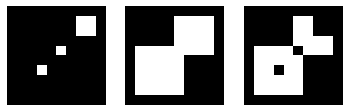

In [33]:
# Joint Maps
andmap = np.logical_and(z1,z3)
ormap = np.logical_or(z1, z3)
conflictmap = np.logical_xor(ormap,andmap)

plt.subplot(1,3,1)
showtif(andmap)
plt.subplot(1,3,2)
showtif(ormap)
plt.subplot(1,3,3)
showtif(conflictmap)

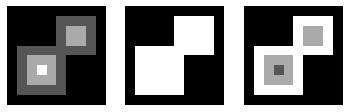

In [34]:

ordist = ndimage.distance_transform_cdt(ormap)
markers = measure.label(ormap)
labeled = watershed(-ordist, markers, mask=ormap)
invordist = ordist.copy()
for i in np.unique(labeled):
    matrixspace = np.where(labeled==i)
    blobmax = np.max(ordist[matrixspace])
    invordist[matrixspace] = (abs((invordist[matrixspace] - blobmax))+1)
invordist = invordist*ormap

plt.subplot(1,3,1)
showtif(ordist)
plt.subplot(1,3,2)
showtif(labeled)
plt.subplot(1,3,3)
showtif(invordist)


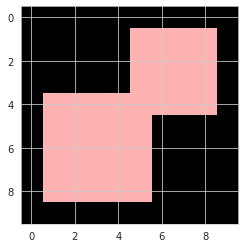

In [35]:
labeledormap = color.label2rgb(labeled,image=ormap, bg_label = 0)
plt.imshow(labeledormap)

# labeled.shape

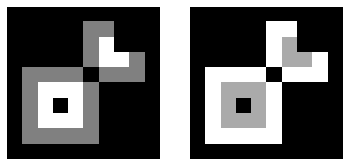

In [36]:
refmap = ordist * conflictmap
invrefmap = invordist * conflictmap
plt.subplot(1,2,1)
showtif(refmap)
plt.subplot(1,2,2)
showtif(invrefmap)

In [37]:
startim = z1
endim = z3
startdist = ndimage.distance_transform_cdt(startim)
enddist = ndimage.distance_transform_cdt(endim)
andmap = np.logical_and(startim,endim)
ormap = np.logical_or(startim,endim)
conflictmap = np.logical_xor(ormap,andmap)

labeled = measure.label(startim)
invstartdist = startdist.copy()
for i in np.unique(labeled):
    matrixspace = np.where(labeled==i)
    blobmax = np.max(startdist[matrixspace])
    invstartdist[matrixspace] = (abs((invstartdist[matrixspace] - blobmax))+1)
invstartdist = invstartdist*startim

labeled = measure.label(endim)
invenddist = enddist.copy()
# For each blob, find the inverted distance map
for i in np.unique(labeled):
    matrixspace = np.where(labeled==i)
    blobmax = np.max(enddist[matrixspace])
    invenddist[matrixspace] = (abs((invenddist[matrixspace] - blobmax))+1)
invenddist = invenddist*endim

startdist = startdist*conflictmap
invstartdist = invstartdist*conflictmap
enddist= enddist*conflictmap
invenddist = invenddist*conflictmap

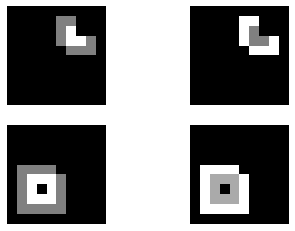

In [38]:
plt.subplot(2,2,1)
showtif(startdist)
plt.subplot(2,2,2)
showtif(invstartdist)
plt.subplot(2,2,3)
showtif(enddist)
plt.subplot(2,2,4)
showtif(invenddist)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 2, 1, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       [0, 1, 2, 2, 2, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 2, 1, 0, 0, 0, 0],
       [0, 1, 2, 2, 2, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

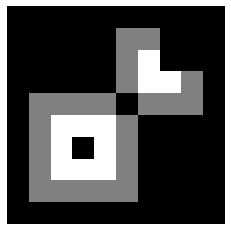

In [39]:
dists = startdist+enddist
invs = invstartdist+invenddist
# a = (startdist<=enddist)
showtif(dists)
dists

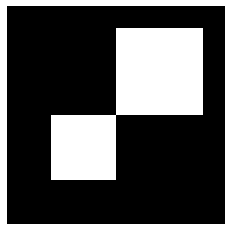

In [40]:
a = np.logical_and((invenddist<=enddist), ormap)
showtif(a)

### Add shrinking and growing

In [41]:
# Starting Images
startim = z1
endim = z3

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startim, endim)
ormap = np.logical_or(startim, endim)
conflictmap = np.logical_xor(ormap, andmap)

# Distance and Inverted Distance Maps
startdist = ndimage.distance_transform_cdt(startim)
labeled = measure.label(startim)
invstartdist = startdist.copy()
for i in range(1,max(np.unique(labeled))+1):
    matrixspace = np.where(labeled == i)
    blobmax = np.max(startdist[matrixspace])+1
    invstartdist[matrixspace] = abs(invstartdist[matrixspace]-blobmax)
# startdist = startdist*conflictmap
# invstartdist = invstartdist *conflictmap

enddist = ndimage.distance_transform_cdt(endim)
labeled = measure.label(endim)
invenddist = enddist.copy()
for i in range(1,max(np.unique(labeled))+1):
    matrixspace = np.where(labeled == i)
    blobmax = np.max(enddist[matrixspace])+1
    invenddist[matrixspace] = abs(invenddist[matrixspace]-blobmax)
enddist = enddist*conflictmap
invenddist = invenddist *conflictmap

# conflictdist = ndimage.distance_transform_cdt(conflictmap)
# labeled = measure.label(conflictmap)
# invconflictdist = conflictdist.copy()
# for i in np.unique(labeled):
#     matrixspace = np.where(labeled==i)
#     blobmax = np.max(conflictdist[matrixspace])
#     invconflictdist[matrixspace] = (((invconflictdist[matrixspace] - blobmax)))
# invconflictdist = invconflictdist
#
ordist = ndimage.distance_transform_cdt(ormap)
labeled = measure.label(ormap)
invordist = ordist.copy()
for i in range(1,max(np.unique(labeled))+1):
    matrixspace = np.where(labeled==i)
    blobmax = np.max(ordist[matrixspace])+1
    invordist[matrixspace] = abs(invordist[matrixspace] - blobmax)
# invordist = invordist*ormap

# # Get the map to use for summing regions
# refmap = ordist * conflictmap
# invrefmap = invordist * conflictmap

# startdist = startdist * conflictmap
# invstartdist = invstartdist * conflictmap
# enddist = enddist * conflictmap
# invenddist = invenddist * conflictmap

0.6666666666666666
0.3333333333333333


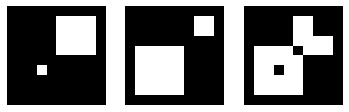

In [42]:
# Starting parameters
zstart = 1
zend = 4
diff = zend-zstart
chunk = 1/diff

znew = 2
zstartweight =chunk*(zend-znew)
zendweight = chunk*(znew-zstart)

plt.subplot(1,3,1)
showtif(startim)
plt.subplot(1,3,2)
showtif(endim)
plt.subplot(1,3,3)
showtif(conflictmap)

# startdist
print(zstartweight)
print(zendweight)

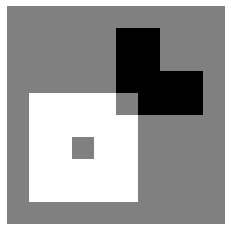

In [43]:
# negative vs. positive for directionality, if end is larger than start (positive) then cell is growing toward end.
diffmap = (endim)-(startim)
showtif(diffmap)
# diffmap

In [44]:
# If values are negative in the above image, the region is shrinking from start to end. Use the inverted distance map of the end image. If the region is growing, use the inverted distance map of the start image.
shrinking = diffmap<0
growing = diffmap>0

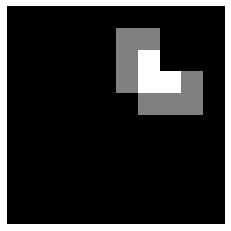

In [45]:
# use the distance map of the larger image (whether start or end)
shrinkingblobs = startdist*shrinking
showtif(shrinkingblobs)
# shrinkingblobs

[1, 2]
1.3333333333333333


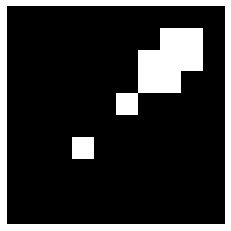

In [46]:
# For values that are shrinking, want the weight of the start image to decrease as the sections increase
sortedvals = sorted(np.unique(shrinkingblobs)[1:])

if len(sortedvals) > 0:
    valrange = np.max(sortedvals)-np.min(sortedvals)
    print(sortedvals)
    shrinkthresh = np.min(sortedvals)+(valrange*zendweight)
    shrinkmap = andmap.copy()
    positivepoints = np.where((startdist>shrinkthresh)&conflictmap)
    shrinkmap[positivepoints] = True
else:
    shrinkmap = andmap.copy()
print(shrinkthresh)
showtif(shrinkmap)

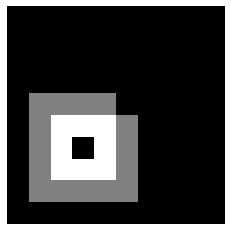

In [47]:
# Do the same for the growing image
growblobs = enddist*growing
showtif(growblobs)

[1, 2]
1.3333333333333333


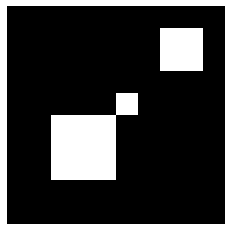

In [48]:
# For values that are growing, want the weight of the start image to increase as the sections increase
sortedvals = sorted(np.unique(growblobs)[1:])
# range(sortedvals[0],sortedvals[-1])

if len(sortedvals) > 0:
    valrange = np.max(sortedvals)-np.min(sortedvals)
    print(sortedvals)
    growthresh = np.min(sortedvals)+(valrange*zendweight)
    growmap = andmap.copy()
    positivepoints = np.where((enddist>=growthresh)&conflictmap)
    growmap[positivepoints] = True
else:
    growmap = andmap.copy()
print(growthresh)
showtif(growmap)

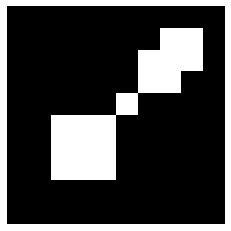

In [49]:
# Bring the two maps together
finalmap = np.logical_or(growmap,shrinkmap,andmap)
showtif(finalmap)

0.3333333333333333


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 3, 3, 3, 0, 0, 0, 0, 0],
       [0, 3, 2, 2, 2, 3, 0, 0, 0, 0],
       [0, 3, 2, 0, 2, 3, 0, 0, 0, 0],
       [0, 3, 2, 2, 2, 3, 0, 0, 0, 0],
       [0, 3, 3, 3, 3, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

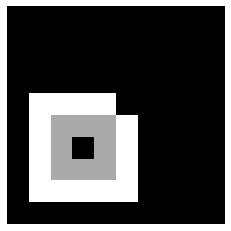

In [50]:
showtif(invenddist)
print(chunk)
invenddist

In [51]:
sortedvals = sorted(np.unique(invenddist)[1:])
# range(sortedvals[0],sortedvals[-1])
valrange = np.max(sortedvals)-np.min(sortedvals)
sortedvals

[2, 3]

In [52]:
# z2 should have the center point and the ring around it, which is value 2
z2Athresh = np.min(sortedvals)+(valrange*zendweight)
z2Athresh

2.3333333333333335

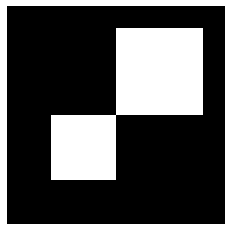

In [53]:
z2A = andmap.copy()
positivepoints = np.where((invenddist<=z2Athresh)&conflictmap)
z2A[positivepoints] = True

showtif(z2A)

## Run on Single Image

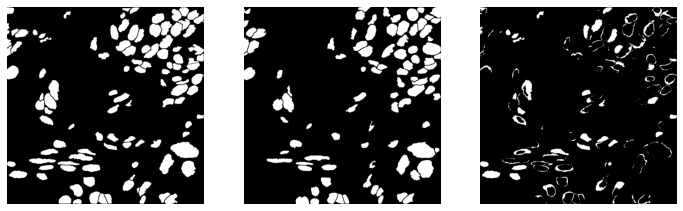

In [54]:
imagefile = imgdf.labelpath[0]
zstart = 1
zend = 4
# test = imagefile[zend]-imagefile[zstart]
plt.figure(figsize=(12,18))
plt.subplot(1,3,1)
showtif(imagefile,zstack=zstart)
plt.subplot(1,3,2)
showtif(imagefile, zstack=zend)
plt.subplot(1,3,3)
showtif((io.imread(imagefile)[zstart])-(io.imread(imagefile)[zend]))

### Pieces

0.6666666666666666
0.3333333333333333


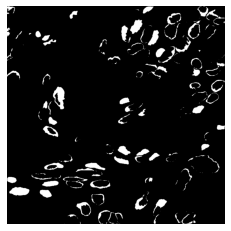

In [55]:

# Starting Images
imagefile = imgdf.labelpath[0]
zstart = 1
zend = 4
diff = zend-zstart
chunk = 1/diff

znew = 2
zstartweight =chunk*(zend-znew)
zendweight = chunk*(znew-zstart)

skimg = io.imread(imagefile, plugin='tifffile')
startim = skimg[zstart]
endim = skimg[zend]

diff = zend-zstart
chunk = 1/diff

startdist = ndimage.distance_transform_cdt(startim)
enddist = ndimage.distance_transform_cdt(endim)

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startim, endim)
ormap = np.logical_or(startim, endim)
conflictmap = np.logical_xor(ormap, andmap)

ordist = ndimage.distance_transform_cdt(ormap)

growing = cv2.subtract(endim,startim)==255
shrinking = cv2.subtract(startim, endim)==255



showtif(shrinking)
print(zstartweight)
print(zendweight)

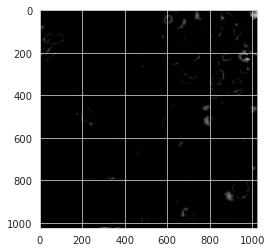

In [56]:
shrinkblobs = startdist*shrinking
growblobs = enddist*growing

plt.imshow(growblobs, cmap='gray')

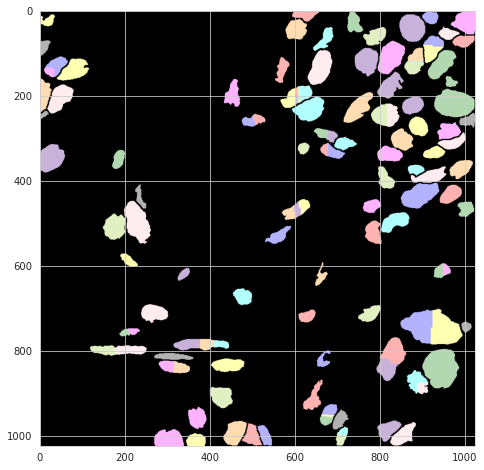

In [57]:

coords = peak_local_max(startdist, footprint=np.ones((50,50)))
mask = np.zeros(startim.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledstart = watershed(startim, markers, mask = startim)

coords = peak_local_max(enddist, footprint=np.ones((50,50)))
mask = np.zeros(endim.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledend = watershed(endim, markers, mask = endim)

labeledstartim = color.label2rgb(labeledstart,image=startim, bg_label = 0)
labeledendim = color.label2rgb(labeledend, image=endim, bg_label = 0)

plt.figure(figsize=(8,8))
plt.imshow(labeledendim)

In [58]:
#Shrinkmap (relies on start im)
shrinkmap = np.zeros(andmap.shape)
for i in range(1,max(np.unique(labeledstart))+1):
    matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
    sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
    if len(sortedvals) > 0:
        shrinkthresh = (np.max(sortedvals))*zstartweight
        positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
        shrinkmap[positivepoints] = True
    else:
        continue

3
0.6666666666666666
2.0


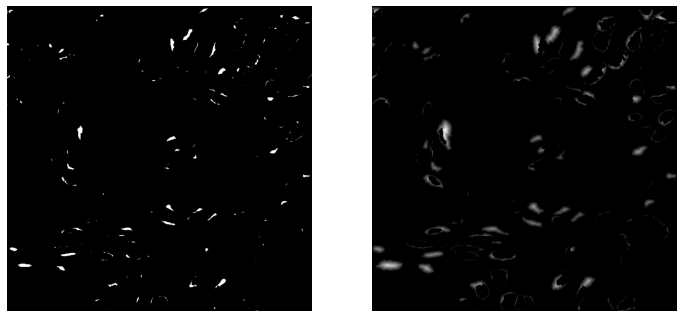

In [59]:
print(np.max(sortedvals))
print(zstartweight)
print(shrinkthresh)

plt.figure(figsize=(12,15))
plt.subplot(1,2,1)
showtif(shrinkmap)
plt.subplot(1,2,2)
showtif(shrinkblobs)

In [60]:
growmap = np.zeros(andmap.shape)
for i in range(1,max(np.unique(labeledend))+1):
    matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
    sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
    if len(sortedvals) > 0:
        growthresh = (np.max(sortedvals))*zendweight
        positivepoints = np.logical_and(enddist>growthresh, matrixspace)
        growmap[positivepoints] = True
    else:
        continue

28
0.3333333333333333
9.333333333333332


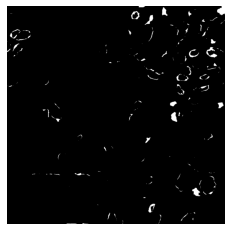

In [61]:
print(np.max(sortedvals))
print(zendweight)
print(growthresh)
showtif(growmap)

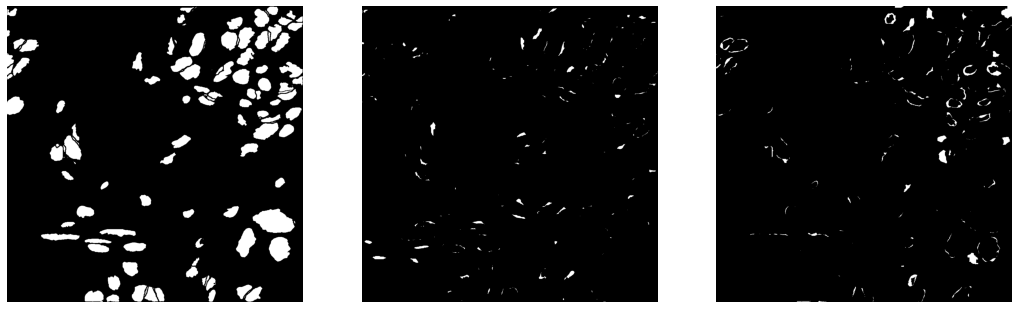

In [62]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
showtif(andmap)
plt.subplot(1,3,2)
showtif(shrinkmap)
plt.subplot(1,3,3)
showtif(growmap)

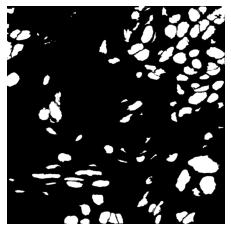

In [63]:
combmap = np.logical_or(growmap,shrinkmap)
finalmap = np.logical_or(andmap,combmap)
showtif(finalmap)
# np.unique(finalmap)

In [64]:
print(shrinkthresh)
print(valrange)
sortedvals


2.0
1


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
21
14.333333333333332


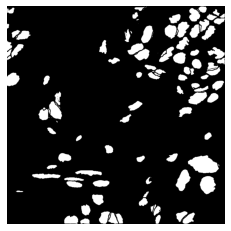

In [65]:
sortedvals = sorted(np.unique(shrinkblobs)[1:])
shrinkmap = andmap.copy()
if len(sortedvals) > 0:
    valrange = np.max(sortedvals)-np.min(sortedvals)
    print(sortedvals)
    shrinkthresh = np.min(sortedvals)+(valrange*zstartweight)
    positivepoints = np.where((startdist>shrinkthresh)&conflictmap)
    shrinkmap[positivepoints] = True
else:
    shrinkmap = andmap.copy()

print(np.max(sortedvals))
print(shrinkthresh)
showtif(shrinkmap)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
28
10.0


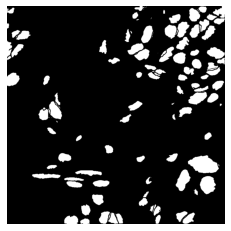

In [66]:
sortedvals = sorted(np.unique(growblobs)[1:])
# range(sortedvals[0],sortedvals[-1])

if len(sortedvals) > 0:
    valrange = np.max(sortedvals)-np.min(sortedvals)
    print(sortedvals)
    growthresh = np.min(sortedvals)+(valrange*zendweight)
    growmap = andmap.copy()
    positivepoints = np.where((enddist>=growthresh)&conflictmap)
    growmap[positivepoints] = True
else:
    growmap = andmap.copy()

print(np.max(sortedvals))
print(growthresh)
showtif(growmap)

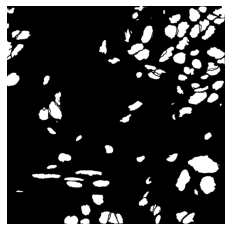

In [67]:
# Bring the two maps together
finalmap = np.logical_or(growmap,shrinkmap,andmap)
showtif(finalmap)

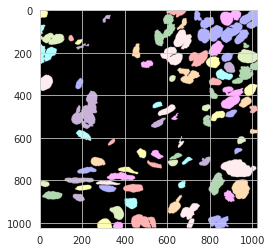

In [68]:
# Starting Images
imagefile = imgdf.labelpath[0]
zstart = 1
zend = 4

skimg = io.imread(imagefile, plugin='tifffile')
startim = skimg[zstart]
endim = skimg[zend]

diff = zend-zstart
chunk = 1/diff

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startim, endim)
ormap = np.logical_or(startim, endim)
conflictmap = np.logical_xor(ormap, andmap)

labeled = measure.label(ormap)

labeledormap = color.label2rgb(labeled,image=ormap, bg_label = 0)
plt.imshow(labeledormap)

### Trial run, all pieces together

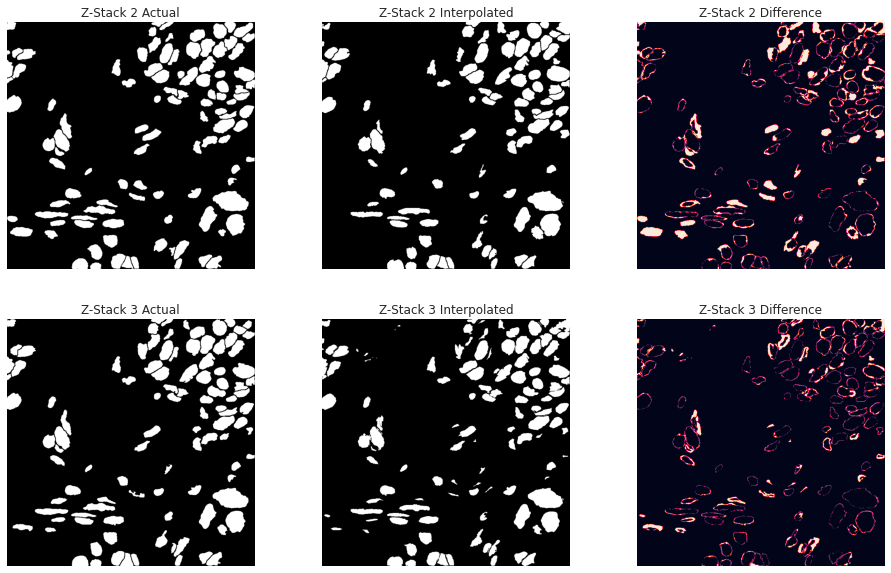

In [69]:
# Together
compare = True

# Starting Images
imagefile = imgdf.labelpath[0]
zstart = 1
zend = 4

skimg = io.imread(imagefile, plugin='tifffile')
startim = skimg[zstart]
endim = skimg[zend]

diff = zend-zstart
chunk = 1/diff

# Distance Maps
startdist = ndimage.distance_transform_cdt(startim)
enddist = ndimage.distance_transform_cdt(endim)

# Find the blob labels for the start and end images with watershed
coords = peak_local_max(startdist, footprint=np.ones((50,50)))
mask = np.zeros(startim.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledstart = watershed(startim, markers, mask = startim)

coords = peak_local_max(enddist, footprint=np.ones((50,50)))
mask = np.zeros(endim.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledend = watershed(endim, markers, mask = endim)

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startim, endim) # intersection
ormap = np.logical_or(startim, endim) # union
conflictmap = np.logical_xor(ormap, andmap)
ordist = ndimage.distance_transform_cdt(ormap)

growing = cv2.subtract(endim,startim)==255
shrinking = cv2.subtract(startim, endim)==255

shrinkblobs = startdist*shrinking
growblobs = enddist*growing

outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
newtifcounter = 0

for i in range(diff-1):
    znew = i+1
    zstartweight = (zend-znew)*chunk
    zendweight = (znew-zstart)*chunk

    shrinkmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledstart))+1):
        matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
        sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            shrinkthresh = (np.max(sortedvals))*zstartweight
            positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
            shrinkmap[positivepoints] = True
        else:
            continue

    growmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledend))+1):
        matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
        sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            growthresh = (np.max(sortedvals))*zendweight
            positivepoints = np.logical_and(enddist>growthresh, matrixspace)
            growmap[positivepoints] = True
        else:
            continue

    combomap = np.logical_or(growmap,shrinkmap)
    newz = np.logical_or(andmap,combomap)
    outtifs[newtifcounter]=newz
    newtifcounter+=1

if compare:
    plt.figure(figsize=(16,10))
    for i in range(diff-1):
        zoffocus = i+1
        actual = skimg[zstart+zoffocus].astype(np.uint8)
        interpolated = outtifs[i].astype(np.uint8)
        # dif = cv2.subtract(actual,interpolated)
        dif = np.logical_xor(actual,interpolated)

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-2)
        plt.title(f'Z-Stack {zstart+zoffocus} Actual')
        plt.axis('off')
        plt.imshow(skimg[zstart+zoffocus],cmap='gray')

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3)-1)
        plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
        plt.axis('off')
        plt.imshow(outtifs[i],cmap='gray')

        plt.subplot(outtifs.shape[0], 3, (zoffocus*3))
        plt.title(f'Z-Stack {zstart+zoffocus} Difference')
        plt.axis('off')
        plt.imshow(dif)

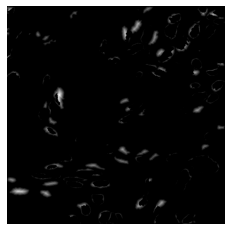

In [70]:
showtif(shrinkblobs)
# showtif(growing)
# showtif(shrinkingblobs)

## Define Function

In [71]:
def interpZv3(imagefile, zstart, zend, compare = True):
    skimg = io.imread(imagefile, plugin='tifffile')
    startim = skimg[zstart]
    endim = skimg[zend]

    diff = zend-zstart
    chunk = 1/diff

    # Distance Maps
    startdist = ndimage.distance_transform_cdt(startim)
    enddist = ndimage.distance_transform_cdt(endim)

    # Find the blob labels for the start and end images with watershed
    coords = peak_local_max(startdist, footprint=np.ones((50,50)))
    mask = np.zeros(startim.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledstart = watershed(startim, markers, mask = startim)

    coords = peak_local_max(enddist, footprint=np.ones((50,50)))
    mask = np.zeros(endim.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledend = watershed(endim, markers, mask = endim)

    # Consensus Regions and Conflict Regions
    andmap = np.logical_and(startim, endim)
    ormap = np.logical_or(startim, endim)
    conflictmap = np.logical_xor(ormap, andmap)
    ordist = ndimage.distance_transform_cdt(ormap)

    growing = cv2.subtract(endim,startim)==255
    shrinking = cv2.subtract(startim, endim)==255

    shrinkblobs = startdist*shrinking
    growblobs = enddist*growing

    outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    newtifcounter = 0

    for i in range(diff-1):
        znew = i+1
        zstartdist = (diff-znew)
        zstartweight = (zstartdist)*chunk
        zendweight = (diff-zstartdist)*chunk
        # print("loop:",i)
        # print("newz:",znew)
        # print("zstartweight:",zstartweight)
        # print("zendweight:",zendweight)

        shrinkmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledstart))+1):
            matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
            sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                shrinkthresh = (np.max(sortedvals))*zstartweight
                positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
                shrinkmap[positivepoints] = True
            else:
                continue

        growmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledend))+1):
            matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
            sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                growthresh = (np.max(sortedvals))*zendweight
                positivepoints = np.logical_and(enddist>growthresh, matrixspace)
                growmap[positivepoints] = True
            else:
                continue

        combomap = np.logical_or(growmap,shrinkmap)
        newz = np.logical_or(andmap,combomap)
        outtifs[newtifcounter]=newz
        newtifcounter+=1
    if compare:
        plt.figure(figsize=(10,15))
        for i in range(diff-1):
            zoffocus = i+1
            actual = skimg[zstart+zoffocus].astype(np.uint8)
            interpolated = outtifs[i].astype(np.uint8)
            dif = np.logical_xor(actual,interpolated)

            plt.subplot(outtifs.shape[0]+2, 3, 2)
            plt.title(f'Z-Stack {zstart} Actual')
            plt.axis('off')
            plt.imshow(skimg[zstart],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-5)
            plt.title(f'Z-Stack {zstart+zoffocus} Actual')
            plt.axis('off')
            plt.imshow(skimg[zstart+zoffocus],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-4)
            plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
            plt.axis('off')
            plt.imshow(outtifs[i],cmap='gray')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-3)
            plt.title(f'Z-Stack {zstart+zoffocus} Difference')
            plt.axis('off')
            plt.imshow(dif, cmap = 'viridis')

            plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-1)
            plt.title(f'Z-Stack {zend} Actual')
            plt.axis('off')
            plt.imshow(skimg[zend], cmap ='gray')

        plt.tight_layout()
        if savefigs:
            plt.savefig(FIGDIR+"Interpolation_Comparison.png")

    return outtifs

### Try on a single image

In [72]:
newtif = interpZv3(imgdf.labelpath[0], zstart=0, zend=3,compare=False)
newtif.shape

(2, 1024, 1024)

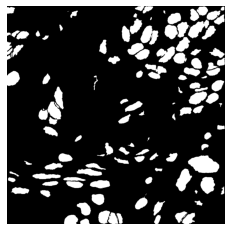

In [73]:
showtif(skimg[zstart])
showtif(newtif[1])

# Function 4

## Single image

In [74]:
testim = imgdf.iloc[0]
testim.imgfolder

'C1-FB323A_CSC_Rd1_11'

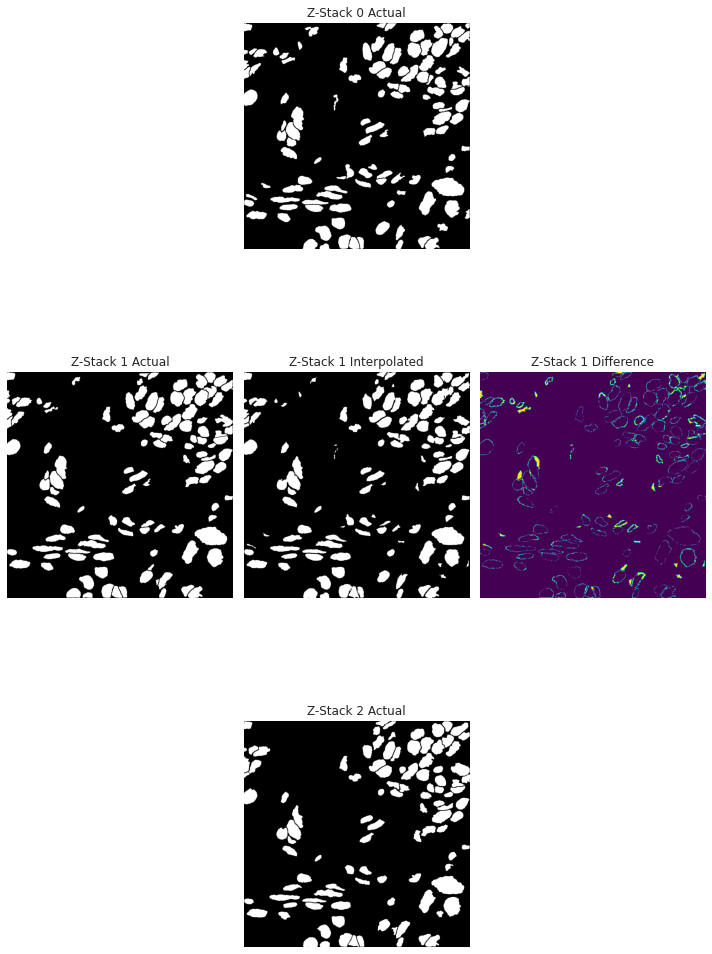

In [75]:
newtif = interpZv3(testim.labelpath, zstart=0, zend=2,compare=True)

In [76]:
testraw = io.imread(testim.imagepath, plugin='tifffile')

(-0.5, 1023.5, 1023.5, -0.5)

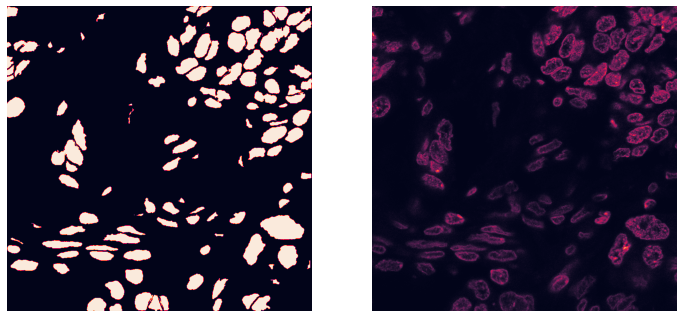

In [77]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(newtif[0])
ax[0].axis('off')
ax[1].imshow(testraw[0])
ax[1].axis('off')

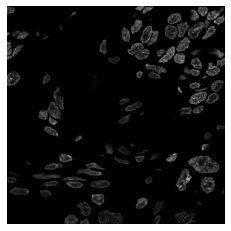

In [78]:
mask = newtif[0]==1
maskedim = testraw[0]*mask
showtif(maskedim)

## Multiple images

In [79]:
zstart = 0
zend = 6

In [80]:
startim = testraw[zstart]
endim = testraw[zend]

(-0.5, 1023.5, 1023.5, -0.5)

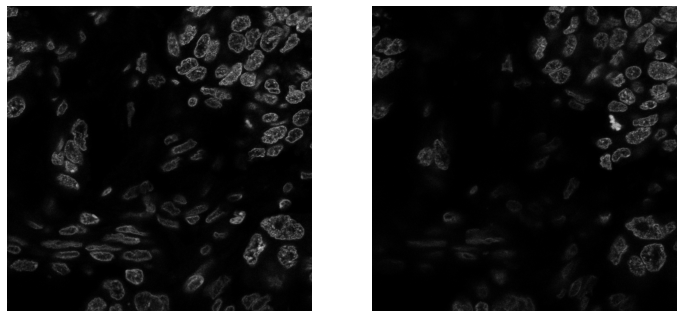

In [81]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(startim, cmap = 'gray')
ax[0].axis('off')
ax[1].imshow(endim, cmap = 'gray')
ax[1].axis('off')

In [82]:
diff = zend-zstart
chunk = 1/diff
print(diff, chunk)

6 0.16666666666666666


In [83]:
intim = cv2.addWeighted(startim,0.5,endim,0.5,0)

(-0.5, 1023.5, 1023.5, -0.5)

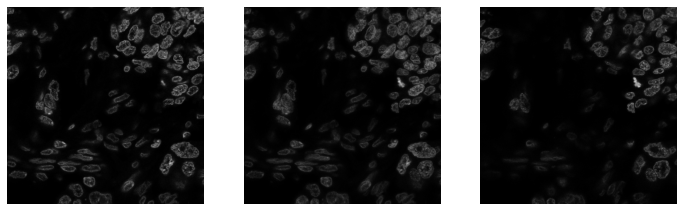

In [84]:
fig, ax = plt.subplots(1,3, figsize = (12,9))
ax[0].imshow(startim, cmap = 'gray')
ax[0].axis('off')
ax[1].imshow(intim, cmap = 'gray')
ax[1].axis('off')
ax[2].imshow(endim, cmap = 'gray')
ax[2].axis('off')

## Pieces

In [85]:
testim = imgdf.iloc[0]
labelfile = testim.labelpath
imgfile = testim.imagepath
print(testim.imgfolder)

# Generating 2 new images
zstart = 0
zend = 3

C1-FB323A_CSC_Rd1_11


In [86]:
# Interpz function
skimg = io.imread(labelfile, plugin='tifffile')
startlab = skimg[zstart]
endlab = skimg[zend]

diff = (zend-zstart)
chunk = 1/diff

print(diff, chunk)

3 0.3333333333333333


In [87]:
# Testing getting the correct weights
for i in range(diff-1):
    znew = i+1
    zstartdist = (diff-znew)
    zstartweight = 1 - (zstartdist)*chunk
    zendweight = 1 - (diff-zstartdist)*chunk

    # Reversing the weights, may be that they are backwards
    # zendweight = (zstartdist)*chunk
    # zstartweight = (diff-zstartdist)*chunk

    print("loop:",i,"newz:",znew,"zstartweight:",zstartweight,"zendweight:",zendweight)

loop: 0 newz: 1 zstartweight: 0.33333333333333337 zendweight: 0.6666666666666667
loop: 1 newz: 2 zstartweight: 0.6666666666666667 zendweight: 0.33333333333333337


In [88]:
# Distance Maps
startdist = ndimage.distance_transform_cdt(startlab)
enddist = ndimage.distance_transform_cdt(endlab)

# Find the blob labels for the start and end images with watershed
coords = peak_local_max(startdist, footprint=np.ones((50,50)))
mask = np.zeros(startlab.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledstart = watershed(startlab, markers, mask = startlab)

coords = peak_local_max(enddist, footprint=np.ones((50,50)))
mask = np.zeros(endlab.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledend = watershed(endlab, markers, mask = endlab)

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startlab, endlab) # intersection
ormap = np.logical_or(startlab, endlab) # union
conflictmap = np.logical_xor(ormap, andmap)
ordist = ndimage.distance_transform_cdt(ormap)

growing = cv2.subtract(endlab,startlab)==255
shrinking = cv2.subtract(startlab, endlab)==255

shrinkblobs = startdist*shrinking
growblobs = enddist*growing

outtifs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
newtifcounter = 0

for i in range(diff-1):
    znew = i+1
    zstartdist = (diff-znew)
    zstartweight = (zstartdist)*chunk
    zendweight = (diff-zstartdist)*chunk

    shrinkmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledstart))+1):
        matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
        sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            shrinkthresh = (np.max(sortedvals))*(1-zstartweight)
            positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
            shrinkmap[positivepoints] = True
        else:
            continue

    growmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledend))+1):
        matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
        sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            growthresh = (np.max(sortedvals))*(1-zendweight)
            positivepoints = np.logical_and(enddist>growthresh, matrixspace)
            growmap[positivepoints] = True
        else:
            continue
    ####
    print(f"Z Start weight for new label {znew}:", zstartweight)
    print(f"Z End weight for new label {znew}:", zendweight)
    ####
    combomap = np.logical_or(growmap,shrinkmap)
    newz = np.logical_or(andmap,combomap)
    outtifs[newtifcounter]=newz
    newtifcounter+=1

Z Start weight for new label 1: 0.6666666666666666
Z End weight for new label 1: 0.3333333333333333
Z Start weight for new label 2: 0.3333333333333333
Z End weight for new label 2: 0.6666666666666666


In [89]:
imgin = io.imread(testim.imagepath, plugin='tifffile')
startim = imgin[zstart]
endim = imgin[zend]

(1024, 1024) 
 Showing Z-stack 1 of 1024


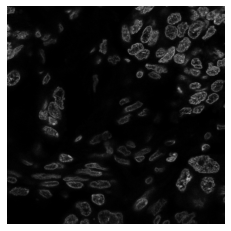

In [90]:
showtif(startim,verbose=True)

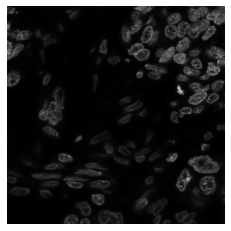

In [91]:
intim = cv2.addWeighted(startim,zstartweight,endim,zendweight,0)
showtif(intim)

(-0.5, 1023.5, 1023.5, -0.5)

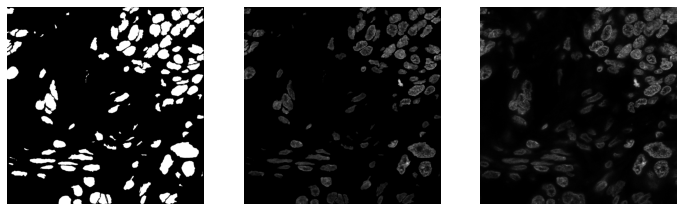

In [92]:
mask = outtifs[1]
maskedim = intim*mask
fig, ax = plt.subplots(1,3, figsize = (12,6))
ax[0].imshow(mask, cmap='gray')
ax[0].axis('off')
ax[1].imshow(maskedim, cmap = 'gray')
ax[1].axis('off')
ax[2].imshow(intim, cmap = 'gray')
ax[2].axis('off')

## Putting image generation in the loop

In [93]:
testim = imgdf.iloc[0]
labelfile = testim.labelpath
imgfile = testim.imagepath
print(testim.imgfolder)

C1-FB323A_CSC_Rd1_11


In [94]:

# Generating 2 new images
zstart = 0
zend = 3

### Interpz function ###
# Bring in the labels
skimg = io.imread(labelfile, plugin='tifffile')
startlab = skimg[zstart]
endlab = skimg[zend]
# Bring in the cell image
imgin = io.imread(testim.imagepath, plugin='tifffile')
startim = imgin[zstart]
endim = imgin[zend]

diff = (zend-zstart)
chunk = 1/diff

# Distance Maps
startdist = ndimage.distance_transform_cdt(startlab)
enddist = ndimage.distance_transform_cdt(endlab)

# Find the blob labels for the start and end images with watershed
coords = peak_local_max(startdist, footprint=np.ones((50,50)))
mask = np.zeros(startlab.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledstart = watershed(startlab, markers, mask = startlab)

coords = peak_local_max(enddist, footprint=np.ones((50,50)))
mask = np.zeros(endlab.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = measure.label(mask)
labeledend = watershed(endlab, markers, mask = endlab)

# Consensus Regions and Conflict Regions
andmap = np.logical_and(startlab, endlab) # intersection
ormap = np.logical_or(startlab, endlab) # union
conflictmap = np.logical_xor(ormap, andmap)
ordist = ndimage.distance_transform_cdt(ormap)

growing = cv2.subtract(endlab,startlab)==255
shrinking = cv2.subtract(startlab, endlab)==255

shrinkblobs = startdist*shrinking
growblobs = enddist*growing

outlabs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
outims = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))

newtifcounter = 0

for i in range(diff-1):
    znew = i+1
    zstartdist = (diff-znew)
    zstartweight = (zstartdist)*chunk
    zendweight = (diff-zstartdist)*chunk

    shrinkmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledstart))+1):
        matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
        sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            shrinkthresh = (np.max(sortedvals))*zstartweight
            positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
            shrinkmap[positivepoints] = True
        else:
            continue

    growmap = np.zeros(andmap.shape)
    for i in range(1,max(np.unique(labeledend))+1):
        matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
        sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
        if len(sortedvals) > 0:
            growthresh = (np.max(sortedvals))*zendweight
            positivepoints = np.logical_and(enddist>growthresh, matrixspace)
            growmap[positivepoints] = True
        else:
            continue

    combomap = np.logical_or(growmap,shrinkmap)
    newz = np.logical_or(andmap,combomap)
    outlabs[newtifcounter]=newz
    ###
    # Create an averaged image using the start and end weights
    intim = cv2.addWeighted(startim,zstartweight,endim,zendweight,0)
    # use the new z for the same level as a mask
    mask = newz
    maskedim = intim*mask
    outims[newtifcounter]=maskedim
    newtifcounter+=1

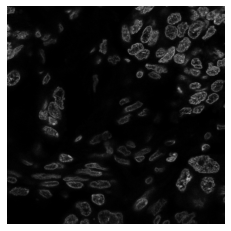

In [95]:
outims.shape
showtif(imgin)

(-0.5, 1023.5, 1023.5, -0.5)

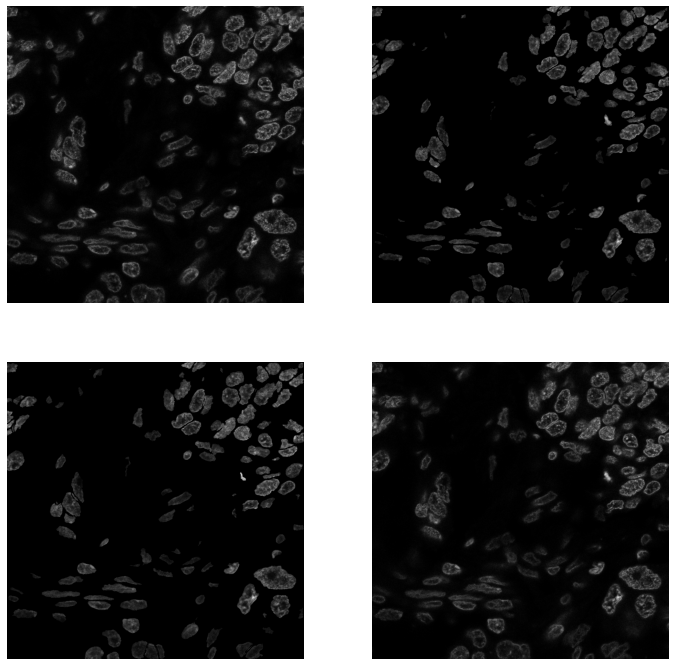

In [96]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize = (12,12))
ax[0,0].imshow(imgin[0], cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(outims[0], cmap = 'gray')
ax[0,1].axis('off')
ax[1,0].imshow(outims[1], cmap = 'gray')
ax[1,0].axis('off')
ax[1,1].imshow(imgin[1], cmap = 'gray')
ax[1,1].axis('off')

## Function

In [97]:
def interpZv4(labelfile, imagefile, zstart, zend, compare = True, savefigs = False):

    # Bring in the labels
    skimg = io.imread(labelfile, plugin='tifffile')
    startlab = skimg[zstart]
    endlab = skimg[zend]

    # Bring in the cell image
    imgin = io.imread(imagefile, plugin='tifffile')
    startim = imgin[zstart]
    endim = imgin[zend]

    diff = zend-zstart
    chunk = 1/diff

    # Distance Maps
    startdist = ndimage.distance_transform_cdt(startlab)
    enddist = ndimage.distance_transform_cdt(endlab)

    # Find the blob labels for the start and end images with watershed
    coords = peak_local_max(startdist, footprint=np.ones((50,50)))
    mask = np.zeros(startlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledstart = watershed(startlab, markers, mask = startlab)

    coords = peak_local_max(enddist, footprint=np.ones((50,50)))
    mask = np.zeros(endlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledend = watershed(endlab, markers, mask = endlab)

    # Consensus Regions and Conflict Regions
    andmap = np.logical_and(startlab, endlab) # intersection
    ormap = np.logical_or(startlab, endlab) # union
    conflictmap = np.logical_xor(ormap, andmap)
    ordist = ndimage.distance_transform_cdt(ormap)

    growing = cv2.subtract(endlab,startlab)==255
    shrinking = cv2.subtract(startlab, endlab)==255

    shrinkblobs = startdist*shrinking
    growblobs = enddist*growing

    outlabs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    outims = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))

    newtifcounter = 0

    for i in range(diff-1):
        znew = i+1
        zstartdist = (diff-znew)
        zstartweight = (zstartdist)*chunk
        zendweight = (diff-zstartdist)*chunk

        shrinkmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledstart))+1):
            matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
            sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                shrinkthresh = (np.max(sortedvals))*(1-zstartweight)
                positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
                shrinkmap[positivepoints] = True
            else:
                continue

        growmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledend))+1):
            matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
            sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                growthresh = (np.max(sortedvals))*(1-zendweight)
                positivepoints = np.logical_and(enddist>growthresh, matrixspace)
                growmap[positivepoints] = True
            else:
                continue

        combomap = np.logical_or(growmap,shrinkmap)
        newz = np.logical_or(andmap,combomap)
        outlabs[newtifcounter]=newz
        ###
        # Create an averaged image using the start and end weights
        intim = cv2.addWeighted(startim,zstartweight,endim,zendweight,0)
        # use the new z for the same level as a mask
        mask = newz.copy()
        maskedim = intim*mask
        outims[newtifcounter]=maskedim
        newtifcounter+=1

    # if compare:
    #         plt.figure(figsize=(10,15))
    #         for i in range(diff-1):
    #             zoffocus = i+1
    #             actual = skimg[zstart+zoffocus].astype(np.uint8)
    #             interpolated = outtifs[i].astype(np.uint8)
    #             dif = np.logical_xor(actual,interpolated)
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, 2)
    #             plt.title(f'Z-Stack {zstart} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-5)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart+zoffocus],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-4)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
    #             plt.axis('off')
    #             plt.imshow(outtifs[i],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-3)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Difference')
    #             plt.axis('off')
    #             plt.imshow(dif, cmap = 'viridis')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-1)
    #             plt.title(f'Z-Stack {zend} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zend], cmap ='gray')
    #
    #         plt.tight_layout()
    #         if savefigs:
    #             plt.savefig(FIGDIR+"Interpolation_Comparison.png")

    return outlabs, outims

### Try on test set

In [98]:
testdf = imgdf.loc[0:4]
testdf = testdf.reset_index(drop=True)
testdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_13,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [99]:
df = testdf

zstart = 0
zend = 3

for i in df.index:
    imname = df.loc[i]
    labelfile = imname.labelpath
    imagefile = imname.imagepath
    outlabs, outims = interpZv4(labelfile=labelfile, imagefile=imagefile, zstart=zstart, zend=zend, compare = False, savefigs = False)
    print(i, imname.imgfolder, outlabs.shape)

0 C1-FB323A_CSC_Rd1_11 (2, 1024, 1024)
1 C1-FB323A_CSC_Rd1_23 (2, 1024, 1024)
2 C1-FB323A_CSC_Rd1_9 (2, 1024, 1024)
3 C1-FB323A_CSC_Rd1_7 (2, 1024, 1024)
4 C1-FB323A_CSC_Rd1_13 (2, 1024, 1024)


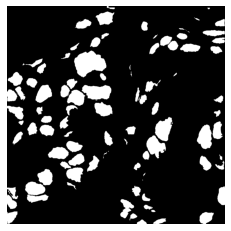

In [100]:
showtif(outlabs[1])

In [101]:
# df = testdf
#
# zstart = 0
# zend = 3
#
# for i in df.index:
#     imname = df.loc[i]
#     labelfile = imname.labelpath
#     imagefile = imname.imagepath
#     outlabs = interpZv3(labelfile, zstart=zstart, zend=zend, compare = False)
#     print(i, imname.imgfolder, outlabs.shape)

In [102]:
# showtif(outlabs[1])

# Set up a Loop to apply a set difference size across the tifs and save the separately

In [103]:
runbatch = True
runbatch = False

saveimgs = True
saveimgs = False

df=testdf
df=imgdf

diffstotry = [2,3,4]

In [104]:
if runbatch:
    for h in diffstotry:
        stackdiff = h
        for i in df.index:
            labelfile = df.iloc[i]['labelpath']
            imgname = df.iloc[i]['imgfolder']
            imagefile = df.loc[i]['imagepath']
            stacks = df.iloc[i]['zlayers']
            interplabs = np.empty((stacks-2,df.iloc[i]['x'],df.iloc[i]['y']))
            interpimgs = np.empty((stacks-2,df.iloc[i]['x'],df.iloc[i]['y']))

            interplayercounter = 0

            for z in range(stacks):
                if z < stackdiff:
                    # print(z, 'continue')
                    continue

                ipzlab, ipzims = interpZv4(labelfile=labelfile, imagefile=imagefile,zstart=z-stackdiff,zend=z,compare=False, savefigs=False)

                # For when there is just a single image (diff = 2), set that as the image.
                if len(ipzlab)==1:
                    interplabs[interplayercounter]=ipzlab
                    interpimgs[interplayercounter]=ipzims
                # For interps with more than 2 images in them, need to decide how to merge them.
                else:
                    # Set the last image from the interpolation as the last image in the output
                    if interplayercounter==stacks:
                        interplabs[interplayercounter]=ipzlab[np.max(ipzlab.shape[0])-1]
                        interpimgs[interplayercounter]=ipzims[np.max(ipzims.shape[0])-1]
                    else:
                        for i in range(ipzlab.shape[0]):
                            interplabs[interplayercounter+i]=ipzlab[i]
                            interpimgs[interplayercounter+i]=ipzims[i]
                # print(z-stackdiff, z, ipzlab.shape,ipzims.shape,interplayercounter)
                interplayercounter += 1
            if saveimgs:
                pilimages = []
                for i in range(interplabs.shape[0]):
                    new = Image.fromarray(interplabs[i])
                    pilimages.append(new)
                outname = 'label_'+str(imgname)+'_interp_diff_'+str(stackdiff)+'.tiff'
                pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

                interpimgtiff = []
                for i in range(interpimgs.shape[0]):
                    newimg = Image.fromarray(interpimgs[i])
                    newimg = newimg.convert("RGB")
                    interpimgtiff.append(newimg)
                imgoutname = 'image_'+str(imgname)+'_interp_diff_'+str(stackdiff)+'.tiff'
                interpimgtiff[0].save(imgoutname,format='TIFF',save_all=True,append_images=interpimgtiff[1:])

In [105]:
# showtif(interpimgs[3],verbose = True)

In [106]:
# showtif(interpimgs)

# Metrics for Interpoaltion Quality

## Proof of Concept

### On Masks

In [233]:
# For masks
# interpfile = '/scratch/ns4964/lionnet/inputs/interpolated/v03 Outimgs/C1-FB323A_CSC_Rd1_1_interp_diff_2.tiff'
interpfile = '/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs/label_C1-FB323A_CSC_Rd1_9_interp_diff_2.tiff'
origfile = '/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_1/label.tif'
origfile = '/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_9/label.tif'
interp = io.imread(interpfile, plugin='tifffile')
orig = io.imread(origfile, plugin='tifffile')
print(orig.shape)
print(interp.shape)

(7, 1024, 1024)
(5, 1024, 1024)


In [234]:
# Subset so they are the same size and values
comp = orig[1:6,...]
comp = (comp>0)*1
print(comp.shape)
print(interp.shape)


(5, 1024, 1024)
(5, 1024, 1024)


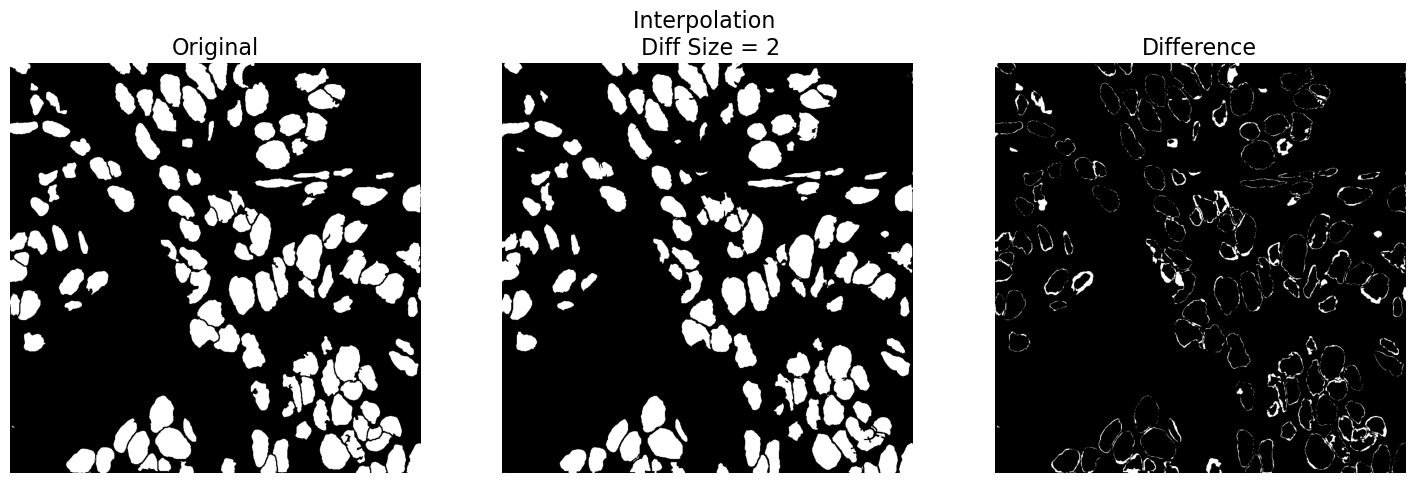

In [235]:
# Check the two images
dif = np.logical_xor(interp[0],comp[0])
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
showtif(comp, zstack=0)
plt.title('Original', fontsize = 16)
plt.subplot(1,3,2)
showtif(interp,zstack=0)
plt.title('Interpolation \n Diff Size = 2', fontsize = 16)
plt.subplot(1,3,3)
plt.title('Difference', fontsize = 16)
showtif(dif)

In [236]:
mse=np.mean(((comp-interp)**2))
mse

0.03763904571533203

### On Images

In [111]:
from skimage.color import rgb2gray
from skimage import img_as_float
interpimg = '/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs/image_C1-FB323A_CSC_Rd1_1_interp_diff_2.tiff'
origimg = '/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_1/image.tif'

interpimg = io.imread(interpimg, plugin='tifffile')
origimg = io.imread(origimg, plugin='tifffile')

interpimg = rgb2gray(interpimg)
interpimg = img_as_float(interpimg)

compimg = origimg[1:6,...]
compimg = img_as_float(compimg)

print(compimg.shape)
print(interpimg.shape)

(5, 1024, 1024)
(5, 1024, 1024)


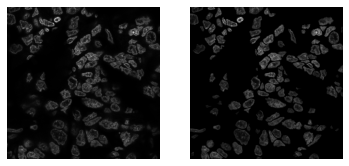

In [112]:
plt.subplot(1,2,1)
showtif(compimg)
plt.subplot(1,2,2)
showtif(interpimg)

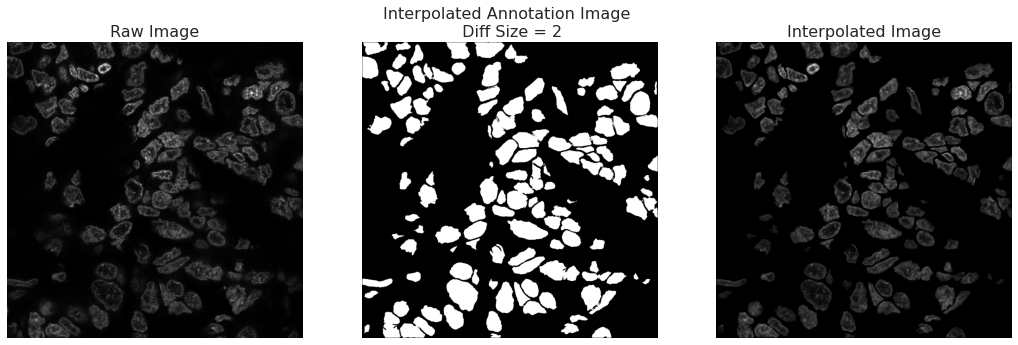

In [113]:
# Check the two images
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
showtif(compimg, zstack=0)
plt.title('Raw Image',fontsize = 16)
plt.subplot(1,3,2)
showtif(interp,zstack=0)
plt.title('Interpolated Annotation Image \n Diff Size = 2', fontsize = 16)
plt.subplot(1,3,3)
plt.title('Interpolated Image', fontsize = 16)
showtif(interpimg)

In [114]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

mse_img = mean_squared_error(compimg[0], interpimg[0])
ssim_img = ssim(compimg[0],interpimg[0])
print(mse_img,ssim_img)

0.0022132515531464387 0.6767310488845114


## Create df for Masks

In [195]:
os.chdir('/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs')
INTERPDIR = os.getcwd()

compdf = imgdf.copy()
#For Labels
compdf = compdf.drop(['imagepath','gappath','zlayers','x','y'],axis=1)
# For Images
# compdf = compdf.drop(['labelpath','gappath','zlayers','x','y'],axis=1)

compdf.columns = ['imagename','origpath']
compdf.insert(2,'diff2',"")
compdf.insert(3,'diff3',"")
compdf.insert(4,'diff4',"")
compdf

,imagename,origpath,diff2,diff3,diff4
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,


In [198]:
maskname = compdf.loc[0]['imagename']
print(maskname)
os.path.join(INTERPDIR,glob.glob("label_"+maskname+"_*_*_4*")[0])

C1-FB323A_CSC_Rd1_1


'/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs/label_C1-FB323A_CSC_Rd1_1_interp_diff_4.tiff'

In [199]:
for i in compdf.index:
    try:
        maskname = compdf.imagename.iloc[i]
        # compdf.at[i,'diff2']=os.path.join(INTERPDIR, glob.glob(imname+"_*_2*")[0])
        # compdf.at[i,'diff3']=os.path.join(INTERPDIR,glob.glob(imname+"_*_3*")[0])
        # compdf.at[i,'diff4']=os.path.join(INTERPDIR,glob.glob(imname+"_*_4*")[0])
        # For labels in v04
        compdf.at[i,'diff2']=os.path.join(INTERPDIR, glob.glob('label_'+maskname+"_*_*_2*")[0])
        compdf.at[i,'diff3']=os.path.join(INTERPDIR,glob.glob('label_'+maskname+"_*_*_3*")[0])
        compdf.at[i,'diff4']=os.path.join(INTERPDIR,glob.glob("label_"+maskname+"_*_*_4*")[0])
    except:
        continue
compdf = pd.melt(compdf,['imagename'],value_name='path')
compdf.columns = ['image','diff','path']
compdf = compdf.sort_values(by=['image','diff'])
compdf.insert(len(compdf.columns),"MSE",0)
compdf.insert(len(compdf.columns),"SSIM",0)
compdf=compdf.reset_index(drop=True)

compdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
1,C1-FB323A_CSC_Rd1_1,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
2,C1-FB323A_CSC_Rd1_1,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
3,C1-FB323A_CSC_Rd1_1,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0
4,C1-FB323A_CSC_Rd1_10,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0
88,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
89,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
90,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0


In [200]:
labelcompdf = compdf.copy()

## Create df for images

In [284]:
os.chdir('/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs')
INTERPDIR = os.getcwd()

compdf = imgdf.copy()
#For Labels
# compdf = compdf.drop(['imagepath','gappath','zlayers','x','y'],axis=1)
# For Images
compdf = compdf.drop(['labelpath','gappath','zlayers','x','y'],axis=1)

compdf.columns = ['imagename','origpath']
compdf.insert(2,'diff2',"")
compdf.insert(3,'diff3',"")
compdf.insert(4,'diff4',"")

In [285]:
compdf

,imagename,origpath,diff2,diff3,diff4
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,,,


In [288]:
imname = compdf.loc[0]['imagename']
print(imname)
os.path.join(INTERPDIR,glob.glob("image_"+imname+"_*_*_4*")[0])

C1-FB323A_CSC_Rd1_1


'/scratch/ns4964/lionnet/inputs/interpolated/v04 Outimgs/image_C1-FB323A_CSC_Rd1_1_interp_diff_4.tiff'

In [289]:
for i in compdf.index:
    try:
        imname = compdf.imagename.iloc[i]
        # compdf.at[i,'diff2']=os.path.join(INTERPDIR, glob.glob(imname+"_*_2*")[0])
        # compdf.at[i,'diff3']=os.path.join(INTERPDIR,glob.glob(imname+"_*_3*")[0])
        # compdf.at[i,'diff4']=os.path.join(INTERPDIR,glob.glob(imname+"_*_4*")[0])
        # For images
        compdf.at[i,'diff2']=os.path.join(INTERPDIR, glob.glob('image_'+imname+"_*_*_2*")[0])
        compdf.at[i,'diff3']=os.path.join(INTERPDIR,glob.glob('image_'+imname+"_*_*_3*")[0])
        compdf.at[i,'diff4']=os.path.join(INTERPDIR,glob.glob("image_"+imname+"_*_*_4*")[0])
    except:
        continue
compdf = pd.melt(compdf,['imagename'],value_name='path')
compdf.columns = ['image','diff','path']
compdf = compdf.sort_values(by=['image','diff'])
compdf.insert(len(compdf.columns),"MSE",0)
compdf.insert(len(compdf.columns),"SSIM",0)
compdf=compdf.reset_index(drop=True)

imgcompdf = compdf.copy()
imgcompdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
1,C1-FB323A_CSC_Rd1_1,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
2,C1-FB323A_CSC_Rd1_1,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
3,C1-FB323A_CSC_Rd1_1,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0
4,C1-FB323A_CSC_Rd1_10,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0
88,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
89,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
90,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0


## Run comparison

### Test Run

In [119]:
minidf = compdf[compdf.image=='C1-FB323A_CSC_Rd1_11']
minidf=minidf.reset_index(drop=True)
minidf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_11,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
1,C1-FB323A_CSC_Rd1_11,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
2,C1-FB323A_CSC_Rd1_11,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
3,C1-FB323A_CSC_Rd1_11,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0


In [120]:
df = minidf

for i in df.index:
    im = df.image.iloc[i]
    origind = df.index[(df['diff'] == 'origpath')&(df['image']==im)].tolist()[0]
    orig = io.imread(df.path.iloc[origind],plugin='tifffile')
    interp = io.imread(df.path.iloc[i],plugin='tifffile')
    if interp.shape[-1]==3:
        interp = rgb2gray(interp)
    else:
        interp= interp[1:6,...]
    interpimg = img_as_float(interp)
    compimg = orig[1:6,...]
    compimg = img_as_float(compimg)

    mse = []
    strucsim = []
    for j in range(compimg.shape[0]):
        mse.append(np.mean(((interpimg[j]-compimg[j])**2)))
        strucsim.append(ssim(compimg[j], interpimg[j]))
    df.at[i,'MSE'] = np.mean(mse)
    df.at[i,'SSIM'] = np.mean(strucsim)

minidf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_11,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.001941,0.688798
1,C1-FB323A_CSC_Rd1_11,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.002431,0.671452
2,C1-FB323A_CSC_Rd1_11,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.003096,0.659982
3,C1-FB323A_CSC_Rd1_11,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0.000000,1.000000


### Full Run

#### Images

In [290]:
import time
df = imgcompdf

start_time = time.time()
for i in df.index:
    im = df.image.iloc[i]
    origind = df.index[(df['diff'] == 'origpath')&(df['image']==im)].tolist()[0]
    orig = io.imread(df.path.iloc[origind],plugin='tifffile')
    interp = io.imread(df.path.iloc[i],plugin='tifffile')
    if interp.shape[-1]==3:
        interp = rgb2gray(interp)
    else:
        interp= interp[1:6,...]
    interpimg = img_as_float(interp)
    compimg = orig[1:6,...]
    compimg = img_as_float(compimg)

    mse = []
    strucsim = []
    for j in range(compimg.shape[0]):
        mse.append(np.mean(((interpimg[j]-compimg[j])**2)))
        strucsim.append(ssim(compimg[j], interpimg[j]))
    df.at[i,'MSE'] = np.mean(mse)
    df.at[i,'SSIM'] = np.mean(strucsim)
print("--- %s seconds ---" % round((time.time() - start_time),0))


--- 90.0 seconds ---


In [291]:
imgcompdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.001965,0.675176
1,C1-FB323A_CSC_Rd1_1,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.002498,0.655083
2,C1-FB323A_CSC_Rd1_1,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.003206,0.638462
3,C1-FB323A_CSC_Rd1_1,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0.000000,1.000000
4,C1-FB323A_CSC_Rd1_10,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.002835,0.625483
...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0.000000,1.000000
88,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.003656,0.646265
89,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.004328,0.626963
90,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.005024,0.617072


#### Masks

In [231]:
labelcompdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.403678,1.0
1,C1-FB323A_CSC_Rd1_1,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.403678,1.0
2,C1-FB323A_CSC_Rd1_1,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.403678,1.0
3,C1-FB323A_CSC_Rd1_1,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0.403678,1.0
4,C1-FB323A_CSC_Rd1_10,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.369786,1.0
...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0.368889,1.0
88,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.043618,1.0
89,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.043618,1.0
90,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.043618,1.0


In [250]:
minidf = compdf[compdf.image=='C1-FB323A_CSC_Rd1_9']
minidf=minidf.reset_index(drop=True)
minidf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
1,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
2,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0,0
3,C1-FB323A_CSC_Rd1_9,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,0


In [282]:
import time
df = minidf
df = labelcompdf

start_time = time.time()
for i in df.index:
    im = df.image.iloc[i]
    origind = df.index[(df['diff'] == 'origpath')&(df['image']==im)].tolist()[0]
    orig = io.imread(df.path.iloc[origind],plugin='tifffile')
    interp = io.imread(df.path.iloc[i],plugin='tifffile')
    if orig.shape != interp.shape:
        orig = orig[1:6,...]
    orig = (orig>0)*1
    mse=np.mean(((orig-interp)**2))
    strucsim = ssim(orig[j], interpimg[j])
    df.at[i,'MSE'] = mse
    df.at[i,'SSIM'] = np.mean(strucsim)

print("--- %s seconds ---" % round((time.time() - start_time),0))

/state/partition1/job-21704173/ipykernel_4047336/1722777953.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  strucsim = ssim(orig[j], interpimg[j])


--- 34.0 seconds ---


In [275]:
labelcompdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.041467,1.0
1,C1-FB323A_CSC_Rd1_1,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.063829,1.0
2,C1-FB323A_CSC_Rd1_1,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.088702,1.0
3,C1-FB323A_CSC_Rd1_1,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,18736.523843,1.0
4,C1-FB323A_CSC_Rd1_10,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.038721,1.0
...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,origpath,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,17670.152192,1.0
88,C1-FB323A_CSC_Rd1_9,diff2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.037639,1.0
89,C1-FB323A_CSC_Rd1_9,diff3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.056177,1.0
90,C1-FB323A_CSC_Rd1_9,diff4,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.078149,1.0


## Plotting

### Images

In [292]:
plotdf = imgcompdf.copy()
plotdf = pd.DataFrame(plotdf)
plotdf = plotdf[(plotdf['diff'] =='diff2')|(plotdf["diff"]=='diff3')|(plotdf["diff"]=='diff4')]
plotdf.loc[plotdf['diff']=='diff2','diff']= 1
plotdf.loc[plotdf['diff']=='diff3','diff']= 2
plotdf.loc[plotdf['diff']=='diff4','diff']= 3
# plotdf['diff'] = plotdf['diff'].astype('float64')

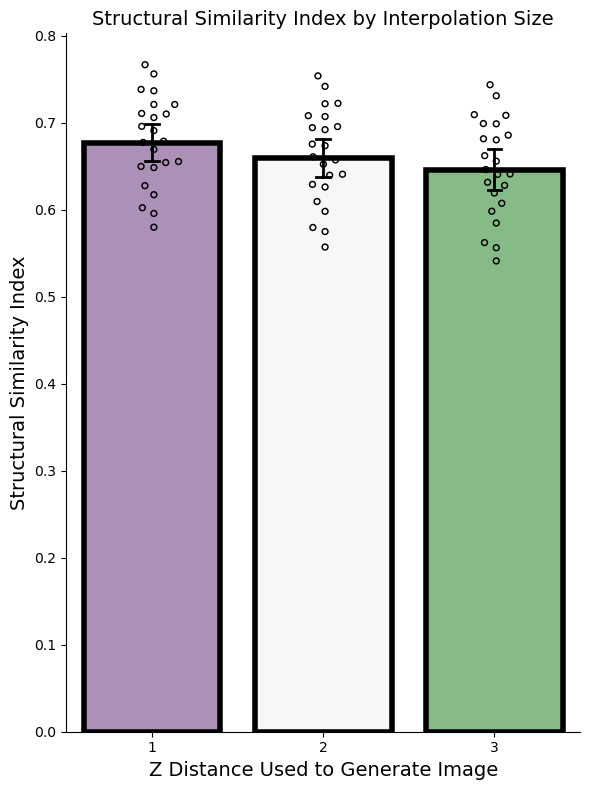

In [300]:
savefigs = True
savefigs = False

plt.style.use('default')

spread_fig, spread_ax = plt.subplots(figsize=(6,8))
sns.barplot(x='diff',
            y='SSIM',
            data=plotdf,
            # fill=False,
            palette = 'PRGn',
            edgecolor = 'black',
            linewidth=4,
            capsize=0.08,
            errwidth=2,
            errcolor='black',
            )
sns.swarmplot(x='diff',
              y='SSIM',
              data=plotdf,
              s=8,
              marker="$\circ$",
              color = 'black'
              # palette = 'colorblind'
              )
plt.xlabel("Z Distance Used to Generate Image", size=14)
plt.ylabel("Structural Similarity Index", size=14)
plt.title("Structural Similarity Index by Interpolation Size", size=14)
plt.xticks()
plt.yticks()
plt.tight_layout()
#
sns.despine()

if savefigs:
    plt.savefig(FIGDIR+"/Difference MSE.png", dpi=300)

In [294]:
# Metrics
from scipy.stats import sem

print("Mean for stack size 1:",plotdf[plotdf['diff']==1].SSIM.mean())
print("Standard error fo the mean for stack size 1:",sem(plotdf[plotdf['diff']==1].SSIM))
print("Mean for stack size 2:",plotdf[plotdf['diff']==2].SSIM.mean())
print("Standard error fo the mean for stack size 2:",sem(plotdf[plotdf['diff']==2].SSIM))
print("Mean for stack size 3:",plotdf[plotdf['diff']==3].SSIM.mean())
print("Standard error fo the mean for stack size 3:",sem(plotdf[plotdf['diff']==3].SSIM))

Mean for stack size 1: 0.6765091301144246
Standard error fo the mean for stack size 1: 0.01082448677722853
Mean for stack size 2: 0.6591983323060604
Standard error fo the mean for stack size 2: 0.011352938669102917
Mean for stack size 3: 0.6462129354926754
Standard error fo the mean for stack size 3: 0.011710739173472597


### Masks

In [280]:
plotdf = labelcompdf.copy()
plotdf = pd.DataFrame(plotdf)
plotdf = plotdf[(plotdf['diff'] =='diff2')|(plotdf["diff"]=='diff3')|(plotdf["diff"]=='diff4')]
plotdf.loc[plotdf['diff']=='diff2','diff']= 1
plotdf.loc[plotdf['diff']=='diff3','diff']= 2
plotdf.loc[plotdf['diff']=='diff4','diff']= 3
# plotdf['diff'] = plotdf['diff'].astype('float64')

In [277]:
plotdf = plotdf[plotdf.image!='C1-FB323A_CSC_Rd1_1']
plotdf = plotdf[plotdf.image!='C1-FB323A_CSC_Rd1_2']
plotdf = plotdf.reset_index(drop=True)
plotdf

,image,diff,path,MSE,SSIM
0,C1-FB323A_CSC_Rd1_10,1,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.038721,1.0
1,C1-FB323A_CSC_Rd1_10,2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.059818,1.0
2,C1-FB323A_CSC_Rd1_10,3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.086334,1.0
3,C1-FB323A_CSC_Rd1_11,1,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.031844,1.0
4,C1-FB323A_CSC_Rd1_11,2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.051669,1.0
...,...,...,...,...,...
58,C1-FB323A_CSC_Rd1_8,2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.057891,1.0
59,C1-FB323A_CSC_Rd1_8,3,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.081489,1.0
60,C1-FB323A_CSC_Rd1_9,1,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.037639,1.0
61,C1-FB323A_CSC_Rd1_9,2,/scratch/ns4964/lionnet/inputs/interpolated/v0...,0.056177,1.0


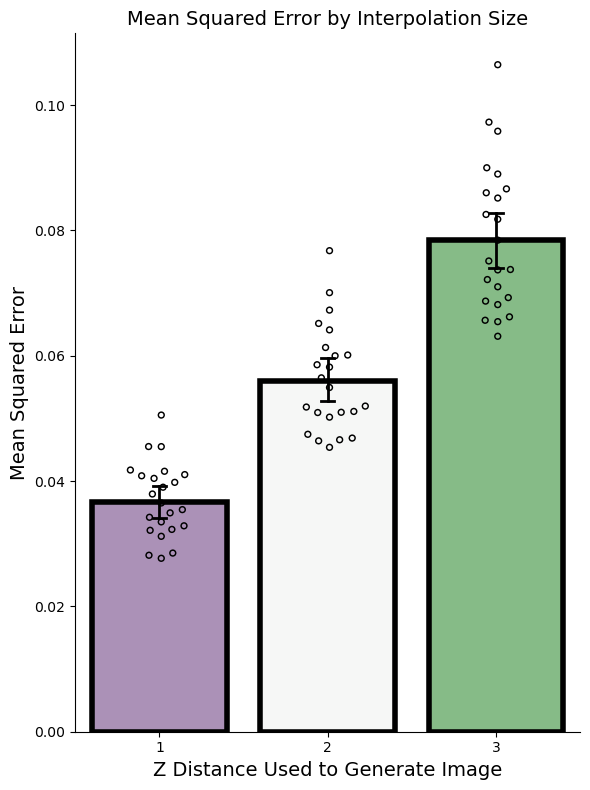

In [281]:
savefigs = True
savefigs = False

plt.style.use('default')

spread_fig, spread_ax = plt.subplots(figsize=(6,8))
sns.barplot(x='diff', y='MSE', data=plotdf,
            # fill=False,
            palette = 'PRGn',
            edgecolor = 'black',
            linewidth=4,
            capsize=0.08,
            errwidth=2,
            errcolor='black',
            )
sns.swarmplot(x='diff',
              y='MSE',
              data=plotdf,
              s=8,
              marker="$\circ$",
              color = 'black'
              # palette = 'colorblind'
              )
plt.xlabel("Z Distance Used to Generate Image", size=14)
plt.ylabel("Mean Squared Error", size=14)
plt.title("Mean Squared Error by Interpolation Size", size=14)
plt.xticks()
plt.yticks()
plt.tight_layout()
#
sns.despine()

if savefigs:
    plt.savefig(FIGDIR+"/Difference MSE.png", dpi=300)

In [279]:
# Metrics

print("Mean for stack size 1:",plotdf[plotdf['diff']==1].MSE.mean())
print("Standard error fo the mean for stack size 1:",sem(plotdf[plotdf['diff']==1].MSE))
print("Mean for stack size 2:",plotdf[plotdf['diff']==2].MSE.mean())
print("Standard error fo the mean for stack size 2:",sem(plotdf[plotdf['diff']==2].MSE))
print("Mean for stack size 3:",plotdf[plotdf['diff']==3].MSE.mean())
print("Standard error fo the mean for stack size 3:",sem(plotdf[plotdf['diff']==3].MSE))

Mean for stack size 1: 0.036086027962820864
Standard error fo the mean for stack size 1: 0.0012768482565664507
Mean for stack size 2: 0.05510552724202474
Standard error fo the mean for stack size 2: 0.0018351714238226333
Mean for stack size 3: 0.07744175138927639
Standard error fo the mean for stack size 3: 0.0025729627547266343


# TODO
